### Set up the data for analysis

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import stan
import nest_asyncio
import arviz as az
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as st
nest_asyncio.apply()
plt.ion()

DATA_DIR = "./Data/Weekly_Counts_of_Deaths_by_State_and_Select_Causes__2014-2019.csv"
df = pd.read_csv(DATA_DIR) 

df = df.iloc[:, :17]  # Drop all the flag
df_usa = df[df['Jurisdiction of Occurrence'] == 'United States']
df = df[df['Jurisdiction of Occurrence'] != 'United States']

sns.set_theme()

In [3]:
# Create the correlation matrix
correlation_matrix = df.iloc[:, 6:].corr()

# Top 3 most correlated diseases for each.
most_correlated_matrix = pd.DataFrame(columns= correlation_matrix.columns)

for i in correlation_matrix.columns:
    most_correlated_matrix[i] = correlation_matrix[i].sort_values(ascending= False)[1:4].index.values

most_correlated_matrix

,Septicemia (A40-A41),Malignant neoplasms (C00-C97),Diabetes mellitus (E10-E14),Alzheimer disease (G30),Influenza and pneumonia (J10-J18),Chronic lower respiratory diseases (J40-J47),"Other diseases of respiratory system (J00-J06,J30-J39,J67,J70-J98)","Nephritis, nephrotic syndrome and nephrosis (N00-N07,N17-N19,N25-N27)","Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99)","Diseases of heart (I00-I09,I11,I13,I20-I51)",Cerebrovascular diseases (I60-I69)
0,"Nephritis, nephrotic syndrome and nephrosis (N...","Diseases of heart (I00-I09,I11,I13,I20-I51)",Cerebrovascular diseases (I60-I69),Diabetes mellitus (E10-E14),"Diseases of heart (I00-I09,I11,I13,I20-I51)","Diseases of heart (I00-I09,I11,I13,I20-I51)","Diseases of heart (I00-I09,I11,I13,I20-I51)","Diseases of heart (I00-I09,I11,I13,I20-I51)","Diseases of heart (I00-I09,I11,I13,I20-I51)",Malignant neoplasms (C00-C97),Malignant neoplasms (C00-C97)
1,"Other diseases of respiratory system (J00-J06,...",Cerebrovascular diseases (I60-I69),Malignant neoplasms (C00-C97),Cerebrovascular diseases (I60-I69),Chronic lower respiratory diseases (J40-J47),Cerebrovascular diseases (I60-I69),"Nephritis, nephrotic syndrome and nephrosis (N...",Malignant neoplasms (C00-C97),Malignant neoplasms (C00-C97),Cerebrovascular diseases (I60-I69),"Diseases of heart (I00-I09,I11,I13,I20-I51)"
2,"Diseases of heart (I00-I09,I11,I13,I20-I51)",Chronic lower respiratory diseases (J40-J47),"Diseases of heart (I00-I09,I11,I13,I20-I51)",Malignant neoplasms (C00-C97),Diabetes mellitus (E10-E14),Malignant neoplasms (C00-C97),Malignant neoplasms (C00-C97),"Other diseases of respiratory system (J00-J06,...",Septicemia (A40-A41),Chronic lower respiratory diseases (J40-J47),Chronic lower respiratory diseases (J40-J47)


Index(['Septicemia (A40-A41)', 'Malignant neoplasms (C00-C97)',
       'Diabetes mellitus (E10-E14)', 'Alzheimer disease (G30)',
       'Influenza and pneumonia (J10-J18)',
       'Chronic lower respiratory diseases (J40-J47)',
       'Other diseases of respiratory system (J00-J06,J30-J39,J67,J70-J98)',
       'Nephritis, nephrotic syndrome and nephrosis (N00-N07,N17-N19,N25-N27)',
       'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99)',
       'Diseases of heart (I00-I09,I11,I13,I20-I51)',
       'Cerebrovascular diseases (I60-I69)'],
      dtype='object')

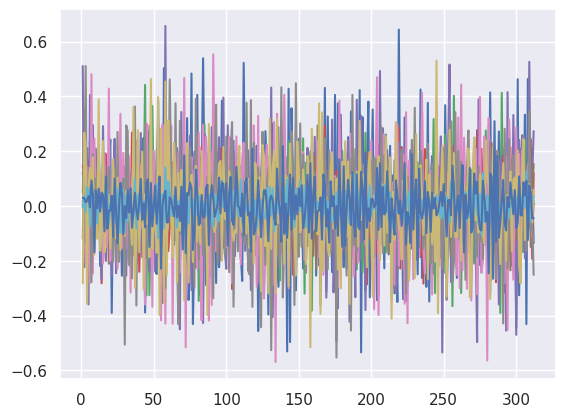

In [4]:
# Setup the data:
state = 'Florida'
df_Florida = df[df['Jurisdiction of Occurrence'] == state].reset_index().drop('index', axis = 1)
ts = np.log(df_Florida.iloc[:, 6:]) # Take log transform - reduce the variance
ts = ts.diff(1)[1:]

# Plot transform data:
ts.plot(legend = False)
ts.columns

### Choosing the model

/home/hieunguyen/Learning/BDA/Project/stan_env/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


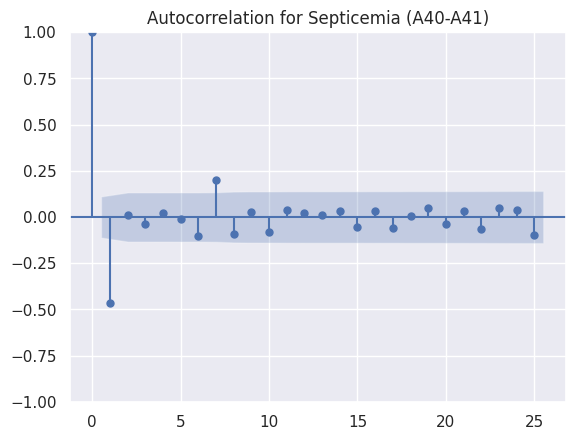

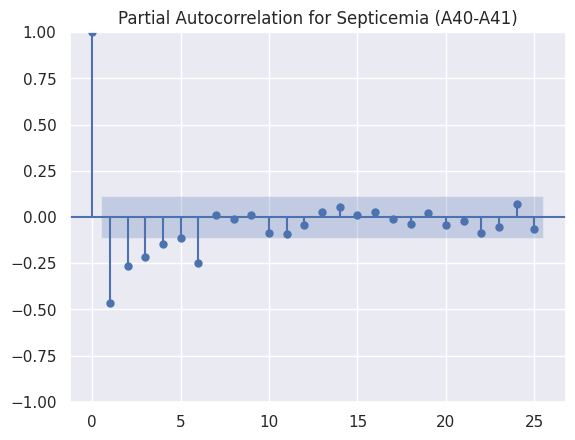

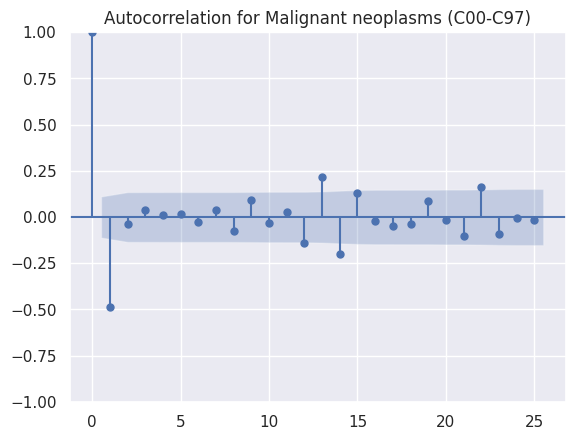

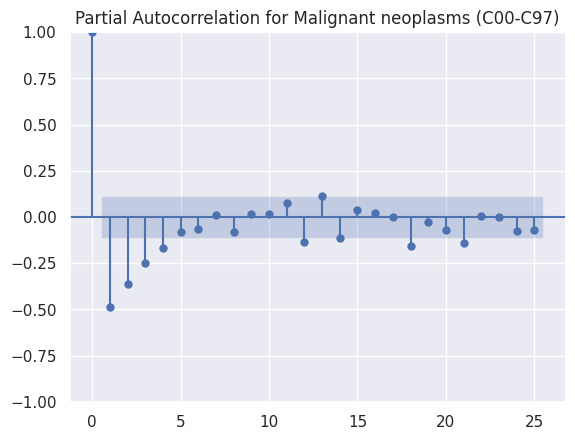

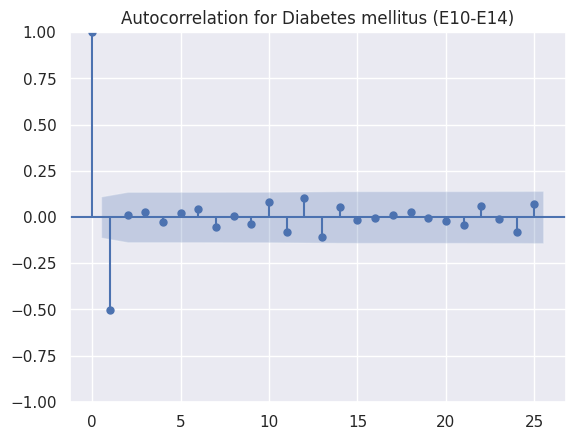

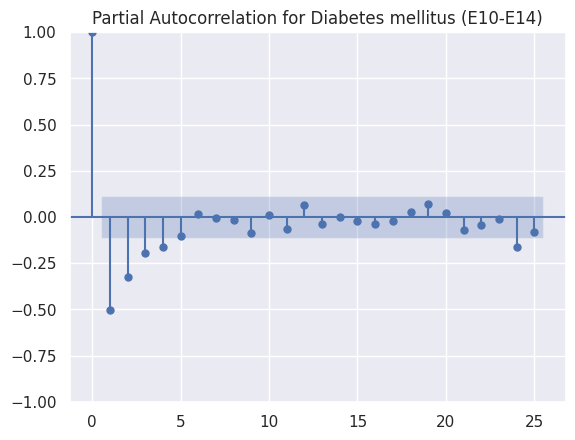

In [5]:
# THis part we would plot the autocorrelation and partial correlation to choose the model
# We only plot 3 different time sereis
for i in range(0, 3):
   tsaplots.plot_acf(ts.iloc[:, i], title= 'Autocorrelation for {}'.format(ts.columns[i]))
   tsaplots.plot_pacf(ts.iloc[:, i], title= 'Partial Autocorrelation for {}'.format(ts.columns[i]))

From the plot above we could see that the autocorrelation disposed after 1 and the partial auto correlation disposed exponentially, which is the properties of the MA(1) model.

### Build the model by Stan

In [29]:
# Read stan model from file

with open('./stan_files/arma.stan', 'r') as my_file:
    arma_models = my_file.read()

uni_variate_model = arma_models.split('//-----')[0]
multi_variate_model = arma_models.split('//-----')[1]

# Models
print(uni_variate_model)
print()
print()
print(multi_variate_model)


# Sample models:
DISEASE = 'Septicemia (A40-A41)'
N = ts.shape[0]
T_exclude = 1
T = N - T_exclude
y = ts[DISEASE].to_numpy()
uni_data = {'T': T, 'y': y[:-T_exclude], 'y_exclude': y[-T_exclude:], 'T_exclude': T_exclude}
uni_posterior = stan.build(uni_variate_model, data= uni_data);
fit_uni = uni_posterior.sample(num_chains= 4, num_samples = 800);
df_uni = fit_uni.to_frame()


data {
  int<lower=20> T;  // number of observations
  int T_exclude; // for validation
  vector[T] y;     // observation at time T
  vector[T_exclude] y_exclude;
}
parameters {
  real mu;              // mean
  real<lower=0> sigma;  // error scale
  real<lower = -1, upper = 1> theta;      // lag coefficients
}
transformed parameters {
  vector[T] epsilon;    // error terms
  epsilon[1] = y[1] - mu;
  for (t in 2:T) {
    epsilon[t] = ( y[t] - mu - theta * epsilon[t - 1]);
  }

  // Exclude error terms
  vector[T_exclude] epsilon_exclude;
  epsilon_exclude[1] = y_exclude[1] - mu - theta * epsilon[T];
  for (t in 2:T_exclude) {
    epsilon_exclude[t] = y_exclude[t] - mu - theta * epsilon_exclude[t - 1];
  }
}
model {
  mu ~ normal(0, 2);
  theta ~ normal(0, 2);
  sigma ~ cauchy(0, 2.5);
  for (t in 2:T) {
    y[t] ~ normal(mu + theta * epsilon[t - 1] , sigma);
  }
}
generated quantities {
   vector[T-1] ypred;
   vector[T-1] log_lik;
   vector[T_exclude] ypred_exclude;
   vector[T_exclu


Building: found in cache, done.Sampling:   0%
Sampling:   3% (200/7200)
Sampling:  12% (900/7200)
Sampling:  38% (2700/7200)
Sampling:  62% (4500/7200)
Sampling:  85% (6100/7200)
Sampling: 100% (7200/7200)
Sampling: 100% (7200/7200), done.
Messages received during sampling:
  Gradient evaluation took 9.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.99 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.95 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_a0x_b66e/model_a4ir24h2.stan', line 31, column 4 to column 55)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler

###  Validating the fit

Convergence checking

In [30]:
# Checking the split R and Effective sample size.

print('Summary of the sampling')
print()
print(az.summary(fit_uni, var_names = ['mu', 'theta', 'sigma']))
print()
print('BFMI values')
print()
print(az.bfmi(fit_uni))

Summary of the sampling

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     0.001  0.003  -0.004    0.006      0.000    0.000    3239.0    1988.0   
theta -0.748  0.043  -0.821   -0.665      0.001    0.001    1990.0    1916.0   
sigma  0.176  0.007   0.163    0.190      0.000    0.000    2122.0    2078.0   

       r_hat  
mu       1.0  
theta    1.0  
sigma    1.0  

BFMI values

[0.92619113 1.02250366 1.08579916 0.87068147]


- The split R close to 1, which means the sampling is well converged for every parameters.


- BFMI quantifies how well momentum resampling matches the marginal energy distribution, BMFI smaller than 0.3 indicate poor sampling, according to this paper https://arxiv.org/pdf/1604.00695v1.pdf. 

### Posterior predictive check.

- Visualization
   - pdf, cdf
   - marginal and CV predictive checing
   - Probability integral transform 

/home/hieunguyen/Learning/BDA/Project/stan_env/lib/python3.10/site-packages/numpy/lib/shape_base.py:1270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)
/home/hieunguyen/Learning/BDA/Project/stan_env/lib/python3.10/site-packages/numpy/lib/shape_base.py:1270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


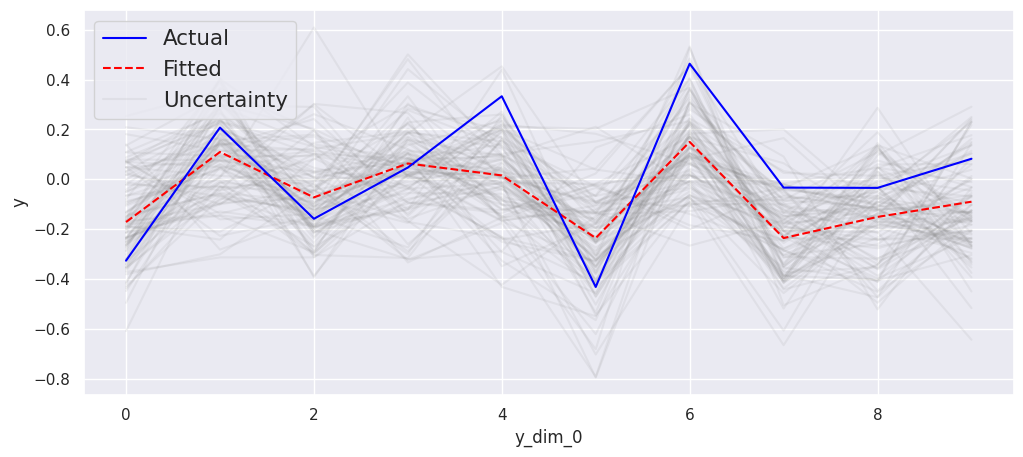

In [31]:
## Generate the model:


start = 300 # Plot part of the data 

fit_uni_inf = az.from_pystan(fit_uni) # Inference Data

obs_data = {
    "y": uni_data['y'][start+1:]
}
posterior_predictive = {
    "y": fit_uni_inf.posterior.ypred[:, :, start:]
 }

# Create new Inference Data for plotting the ttime series.

idata = az.from_dict(
    observed_data=obs_data,
    posterior_predictive=posterior_predictive,
)
ax = az.plot_ts(idata=idata, y="y")

### LFO Cross-validation


This part based on the instruction provided in this link: https://mc-stan.org/loo/articles/loo2-lfo.html


The idea is the normal Loo method would be misleading since we had made the past value 
affected by the future value. As the result, LFO would be our choice, and, to tackle the 
problem of refitting the data multiple time, we would follow the instruction on using 
the Psis provided by the link above.


The AR model is typically not good for predicting long into the future, thus in this project, we only interested in the 1-step ahead predcition.

In [32]:
## Benchmark using loo.

az.loo(az.from_pystan(fit_uni))

Computed from 3200 posterior samples and 310 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -302.89    40.23
p_loo       22.71        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      310  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [11]:
# Helper function:

# log(sum(exp(x)))
def log_sum_exp(x):
    max_x = np.max(x)
    return max_x + np.log(np.sum(np.exp(x - max_x)))

# log(mean(exp(x)))
def log_mean_exp(x):
    return log_sum_exp(x) - np.log(len(x))

# compute log of raw imporance ratio
# sum over observations not over posterior

def sum_log_ratios(loglik, ids = None):
    if not ids == None:
        loglik = loglik[:, list(ids)]  # To keep the dimension of the matrix
    return np.sum(loglik, axis = 1)

# Create a SamplerWrapper for refitting purpose

dims = {'y': ['time'], 'ypred': ['time'], 'log_likelihood': ['time']}
idata_kwargs = {
    'posterior_predictive': 'ypred',
    'observed_data': 'y',
    'log_likelihood': ['log_lik'],
    'dims': dims
}
idata = az.from_pystan(posterior= fit_uni, posterior_model= uni_posterior, **idata_kwargs)
# Wrapper class: 
pystan_wrapper = az.PyStanSamplingWrapper(uni_variate_model, 
                                          idata_orig= idata, 
                                          idata_kwargs= idata_kwargs, 
                                          sample_kwargs= {'num_chains': 4, 'num_samples': 800})

## Estimating the LFO by Pareto:
L = 20
k_thresh = 0.7

app_elpds = np.empty(N)

# Initialize the process for i = L

past = L
oos = L+1
data_past = {'T': L, 'T_exclude': N - L, 'y': y[0:past], 'y_exclude': y[past: N] }
fit_uni_past = pystan_wrapper.sample(data_past)
loglik = pystan_wrapper.get_inference_data(fit_uni_past)
    
# log_likelihood = az.from_pystan(fit_uni).log_likelihood['log_lik'].stack(__sample__=["chain", "draw"])
# report = az.psislw(-log_likelihood.data[0], reff = 0.8)
# report
loglik

Building...



Building: found in cache, done.Sampling:   0%
Sampling:  25% (1800/7200)
Sampling:  50% (3600/7200)
Sampling:  75% (5400/7200)
Sampling: 100% (7200/7200)
Sampling: 100% (7200/7200), done.
Messages received during sampling:
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_sg6bl019/model_ynn74jif.stan', line 22, column 4 to column 55)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition 

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats

In [18]:
y[range(0,2).]

array([0.12361396, 0.02298952])

In [57]:
x = np.array([[1,6, 3], [2,9, 7]])
x[:, [0]]

array([[1],
       [2]])

## Multivariate model

In [105]:

parameters = df1.iloc[:, 7:].mean(axis = 0)
parameters

parameters
mu.1        -0.236045
mu.2        -0.471390
phi.1.1      0.684879
phi.2.1     -0.291926
phi.1.2      0.472734
phi.2.2      0.075860
theta.1.1   -0.478545
theta.2.1   -0.563295
theta.1.2   -0.074055
theta.2.2   -0.209777
sigma.1.1    0.031730
sigma.2.1   -0.095101
sigma.1.2   -0.095101
sigma.2.2    0.968745
dtype: float64

In [114]:
mu = parameters[['mu.1', 'mu.2']].values
phi = parameters[['phi.1.1', 'phi.1.2', 'phi.2.1', 'phi.2.2']].values.reshape(2, -1)
theta = parameters[['theta.1.1', 'theta.1.2', 'theta.2.1', 'theta.2.2']].values.reshape(2, -1)
sigma = parameters[['sigma.1.1', 'sigma.1.2', 'sigma.2.1', 'sigma.2.2']].values.reshape(2, -1)

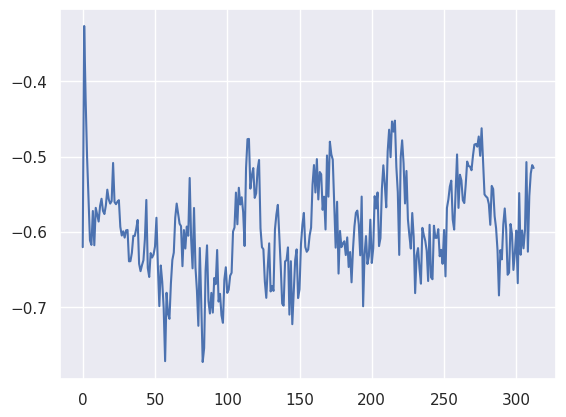

In [132]:
nu = np.empty((2, T))
err = np.empty((2, T))
nu[:, 0] = mu + phi.dot(mu)
err[:, 1] = y[:, 1] - nu[:, 1]
for t in range(1, T):
    nu[:, t] = mu + phi.dot(y[:, t-1]) + theta.dot(err[:, t-1])
    err[:, t] = y[:, t] - nu[:, t]

plt.plot(nu[0, :])



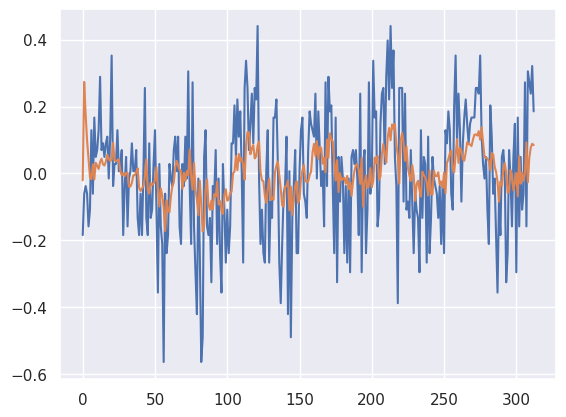

In [135]:
plt.plot(y[0, :])
plt.plot(nu[0, :] + 0.6)

In [58]:
az.from_pystan(fit_uni)

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats